<a href="https://colab.research.google.com/github/shabanibadi/Image-Enhancement/blob/main/Fuzzy_Logic_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries:**

In [3]:
import cv2 as cv
import numpy as np
import math
import time
from matplotlib import pyplot as plt

**Define Constants:**

In [4]:
n = 2 # number of rows (windows on columns)
m = 2 # number of colomns (windows on rows)
EPSILON = 0.00001
#GAMMA, IDEAL_VARIANCE 'maybe' have to changed from image to another 
GAMMA = 1 # Big GAMMA >> Big mean >> More Brightness
IDEAL_VARIANCE = 0.35 #Big value >> Big variance >> Big lambda >> more contrast

**Call Image:**

In [6]:
img = cv.imread('/content/einstein.PNG')
#img = cv.resize(img, (200, 200))
layer = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
WIDTH = layer.shape[1]
HEIGHT = layer.shape[0]
x0, x1, y0, y1 = 0, WIDTH - 1, 0, HEIGHT - 1

**Define Functions:**

In [7]:

# split the image to windows
def phy(value): # phy: E --> R 
    #if ((1+value)/((1-value)+0.0001)) < 0:
    #print(value)
    return 0.5 * np.log((1+value)/((1-value)+EPSILON))

def multiplication(value1, value2): # ExE --> R
    return phy(value1) * phy(value2)

def norm(value):
    return abs(phy(value))

def scalar_multiplication(scalar, value):# value in E ([-1,1])
    s = (1+value)**scalar
    z = (1-value)**scalar
    res = (s-z)/(s+z+EPSILON)
    return res

def addition(value1, value2): # value1,value2 are in E ([-1,1])
    res = (value1+value2)/(1+(value1*value2)+EPSILON)
    return res

def subtract(value1, value2): # value1,value2 are in E ([-1,1])
    res = (value1-value2)/(1-(value1*value2)+EPSILON)
    return res

def C(m,i):
    return math.factorial(m)/((math.factorial(i)*math.factorial(m-i))+EPSILON)

def qx(i, x): # i: window index in rows, x: number of current pixel on x-axis
    if (x == WIDTH - 1):
        return 0
    return C(m,i)*(np.power((x-x0)/(x1-x), i) * np.power((x1-x)/(x1-x0), m)) #This is the seconf implementation
    #return C(m,i)*((np.power(x-x0,i) * np.power(x1-x,m-i)) / (np.power(x1-x0,m)+EPSILON))

def qy(j, y):
    '''
    The second implementation for the formula does not go into overflow.
    '''
    if (y == HEIGHT - 1):
        return 0
    return C(n,j)*(np.power((y-y0)/(y1-y), j) * np.power((y1-y)/(y1-y0), n)) #This is the seconf implementation
    #return C(n,j)*((np.power((y-y0),j) * np.power((y1-y),n-j))/ (np.power(y1-y0,n)+EPSILON))
    
def p(i, j, x, y):
    return qx(i, x) * qy(j, y)

def mapping(img, source, dest):
    return (dest[1] - dest[0])*((img - source[0]) / (source[1] - source[0])) + dest[0]

**Image Fuzzification:**

In [8]:
e_layer_gray = mapping(layer, (0, 255), (-1, 1))

**Calculate Ps and Ws**

In [9]:
def cal_ps_ws(m, n, w, h, gamma):
    ps = np.zeros((m, n, w, h))
    for i in range(m):
        for j in range(n):
            for k in range(w):
                for l in range(h):    
                    ps[i, j, k, l] = p(i, j, k, l)

    ws = np.zeros((m, n, w, h))
    for i in range(m):
        for j in range(n):
            ps_power_gamma = np.power(ps[i, j], gamma)
            for k in range(w):
                for l in range(h):    
                    ws[i, j, k, l] = ps_power_gamma[k, l] / (np.sum(ps[:, :, k, l])+EPSILON)
    return ps, ws
print('Ps and Ws calculation is in progress...')
start = time.time()
ps, ws = cal_ps_ws(m, n, WIDTH, HEIGHT, GAMMA)
end = time.time()
print('Ps and Ws calculation has completed successfully in '+str(end-start)+' s')

Ps and Ws calculation is in progress...
Ps and Ws calculation has completed successfully in 3.236640453338623 s


**Calculate cards, means, variances, lambdas**

In [10]:
def cal_means_variances_lambdas(w, e_layer):
    means = np.zeros((m, n))
    variances = np.zeros((m, n))
    lambdas = np.zeros((m, n))
    taos = np.zeros((m, n))
    def window_card(w):
        return np.sum(w)

    def window_mean(w, i, j):
        mean = 0
        for k in range(HEIGHT):
            for l in range(WIDTH):
                mean = addition(mean, scalar_multiplication(w[i, j, l, k], e_layer[k, l]))
        mean /= window_card(w[i, j])
        return mean

    def window_variance(w, i, j):
        variance = 0
        for k in range(HEIGHT):
            for l in range(WIDTH):
                variance += w[i, j, l, k] * np.power(norm(subtract(e_layer[k, l], means[i, j])), 2)
        variance /= window_card(w[i, j])
        return variance

    def window_lambda(w, i, j):
        return np.sqrt(IDEAL_VARIANCE) / (np.sqrt(variances[i, j])+EPSILON)

    def window_tao(w, i, j):
        return window_mean(w, i, j)

    for i in range(m):
        for j in range(n):
            means[i, j] = window_mean(ws, i, j)
            variances[i, j] = window_variance(ws, i, j)
            lambdas[i, j] = window_lambda(ws, i, j)
    taos = means.copy()
    
    return means, variances, lambdas, taos
print('means, variances, lambdas and taos calculation is in progress...')
start = time.time()
means, variances, lambdas, taos = cal_means_variances_lambdas(ws, e_layer_gray)
end = time.time()
print('means, variances, lambdas and taos calculation is finished in ' + str(end-start) + ' s')

means, variances, lambdas and taos calculation is in progress...
means, variances, lambdas and taos calculation is finished in 1.6595194339752197 s


**Implement Fuzzy Enhancement:**

In [11]:
def window_enh(w, i, j, e_layer):
    return scalar_multiplication(lambdas[i, j], subtract(e_layer, taos[i, j]))

**Implement Image Enhancement:**

In [12]:

def image_enh(w, e_layer):
    new_image = np.zeros(e_layer.shape)
    width = e_layer.shape[1]
    height = e_layer.shape[0]
    for i in range(m):
        for j in range(n):
            win = window_enh(w, i, j, e_layer)
            w1 = w[i, j].T.copy()
            for k in range(width):
                for l in range(height):
                    new_image[l, k] = addition(new_image[l, k], scalar_multiplication(w1[l, k], win[l, k]))
    return new_image

**One Layer Enhancement Function:**

In [13]:
def one_layer_enhancement(e_layer):
    #card_image = layer.shape[0]*layer.shape[1]
    new_E_image = image_enh(ws, e_layer)
    res_image = mapping(new_E_image, (-1, 1), (0, 255))
    res_image = np.round(res_image)
    res_image = res_image.astype(np.uint8)
    return res_image

**Implement Fuzzy Enhancement:**

In [14]:
res_img = one_layer_enhancement(e_layer_gray)

**Result:**

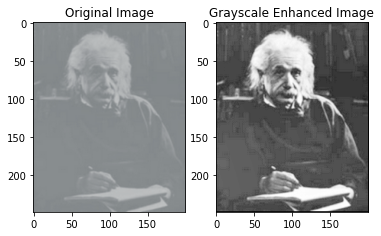

In [15]:

plt.subplot(1, 2, 1)
plt.imshow(img, cmap = 'gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(res_img, cmap = 'gray')
plt.title('Grayscale Enhanced Image')
plt.show()

**RGB Color Space Image Enhancement:**

In [17]:
#Constants
n = 2 # number of rows (windows)
m = 2 # number of colomns (windows)
GAMMA = 1
EPSILON = 0.00001
IDEAL_VARIANCE = 0.35

#Call image

img = cv.imread('/content/street.JPG')
WIDTH = img.shape[1]
HEIGHT = img.shape[0]
x0, x1, y0, y1 = 0, WIDTH - 1, 0, HEIGHT - 1

#Image fuzzification
layer_b, layer_g, layer_r = cv.split(img)
e_layer_b, e_layer_g, e_layer_r = mapping(layer_b, (0, 255), (-1, 1)), mapping(layer_g, (0, 255), (-1, 1)), mapping(layer_r, (0, 255), (-1, 1))
e_layer_rgb = scalar_multiplication(1/3, addition(addition(e_layer_b, e_layer_g), e_layer_r)) #Mean of the three layers

#Cal Ps, Ws
ps, ws = cal_ps_ws(m, n, WIDTH, HEIGHT, GAMMA)

#Cal means, variances, lambdas, taos
means, variances, lambdas, taos = cal_means_variances_lambdas(ws, e_layer_rgb)

#Layers enhancement
res_r = one_layer_enhancement(e_layer_r)
res_g = one_layer_enhancement(e_layer_g)
res_b = one_layer_enhancement(e_layer_b)
res_img = cv.merge([res_b, res_g, res_r])

**Result:**

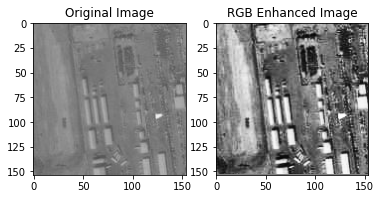

In [18]:

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(res_img, cv.COLOR_BGR2RGB))
plt.title('RGB Enhanced Image')
plt.show()